<a href="https://colab.research.google.com/github/ShreyaTripathi1/Research-on-Fairness-Optimization-in-ML-Models/blob/main/Fair_Decision_Making_via_Automated_Repair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

In [ ]:
# Load COMPAS dataset from GitHub
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

In [ ]:
# Select relevant columns
columns = ["age", "sex", "race", "priors_count", "two_year_recid", "c_charge_degree"]
df = df[columns].dropna()

# Encode categorical variables
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["race"] = df["race"].apply(lambda x: 1 if x == "African-American" else 0)  # Sensitive attribute
df["c_charge_degree"] = df["c_charge_degree"].map({"F": 1, "M": 0})  # Felony=1, Misdemeanor=0

# Define Features & Target
X = df.drop(columns=["two_year_recid"])  # Features
y = df["two_year_recid"]  # Label (1 = Recidivate, 0 = No Recidivate)
sensitive_attr = df["race"]  # African-American = 1, Others = 0

# Split Data
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive_attr, test_size=0.3, random_state=42)

# **Training Models**

##**1. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 📌 Step 6: Train Decision Tree Model
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# 📌 Step 7: Make Predictions
y_pred = clf.predict(X_test)

# 📌 Step 8: Evaluate Baseline Performance
acc_before = accuracy_score(y_test, y_pred)

# 📌 Step 9: Compute Fairness Metrics Before FairRepair
dpd_before = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
eod_before = equalized_odds_difference(y_test, y_pred, sensitive_features=s_test)

print(f"🔹 Baseline Accuracy: {acc_before:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before:.4f}")



🔹 Baseline Accuracy: 0.6919
🔹 Demographic Parity Difference Before: 0.2196
🔹 Equalized Odds Difference Before: 0.2075


In [ ]:
# 📌 Step 10: Apply FairRepair
def fair_repair(y_pred, sensitive_attr):
    """
    Adjusts predictions to balance demographic parity by flipping some predictions.
    """
    # Ensure indices are aligned
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    sensitive_attr = pd.Series(sensitive_attr).reset_index(drop=True)

    p1 = np.mean(y_pred[sensitive_attr == 1])  # African-American group
    p0 = np.mean(y_pred[sensitive_attr == 0])  # Other groups

    # If there's a significant bias, adjust predictions
    if abs(p1 - p0) > 0.1:
        mask = (sensitive_attr == 1) & (y_pred == 1)
        mask_indices = mask[mask].index  # Get indices where mask is True

        flip_count = int(len(mask_indices) * 0.2)  # Adjust 20% of predictions
        flip_indices = np.random.choice(mask_indices, flip_count, replace=False)

        y_pred.iloc[flip_indices] = 0  # Change prediction to 'low-risk'

    return y_pred

# Apply FairRepair
y_pred_repaired = fair_repair(y_pred, s_test)

# 📌 Step 11: Evaluate Fairness After FairRepair
acc_after = accuracy_score(y_test, y_pred_repaired)

# 📌 Step 12: Compute Fairness Metrics After FairRepair
dpd_after = demographic_parity_difference(y_test, y_pred_repaired, sensitive_features=s_test)
eod_after = equalized_odds_difference(y_test, y_pred_repaired, sensitive_features=s_test)

print("\n✅ After Applying FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after:.4f}")



✅ After Applying FairRepair:
🔹 FairRepaired Accuracy: 0.6693
🔹 Demographic Parity Difference After: 0.1126
🔹 Equalized Odds Difference After: 0.0637


In [ ]:
# 📌 Step 13: Compare Before & After
print("\n🟢 Fairness Improvement Summary:")
print(f"📉 Demographic Parity Difference: {dpd_before:.4f} → {dpd_after:.4f}")
print(f"📉 Equalized Odds Difference: {eod_before:.4f} → {eod_after:.4f}")


🟢 Fairness Improvement Summary:
📉 Demographic Parity Difference: 0.2196 → 0.1126
📉 Equalized Odds Difference: 0.2075 → 0.0637


---

## **2. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)

# Make Predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_rf = accuracy_score(y_test, y_pred_rf)

# Compute Fairness Metrics Before FairRepair
dpd_before_rf = demographic_parity_difference(y_test, y_pred_rf, sensitive_features=s_test)
eod_before_rf = equalized_odds_difference(y_test, y_pred_rf, sensitive_features=s_test)

# Apply FairRepair
y_pred_rf_repaired = fair_repair(y_pred_rf, s_test)

# Evaluate Fairness After FairRepair
acc_after_rf = accuracy_score(y_test, y_pred_rf_repaired)
dpd_after_rf = demographic_parity_difference(y_test, y_pred_rf_repaired, sensitive_features=s_test)
eod_after_rf = equalized_odds_difference(y_test, y_pred_rf_repaired, sensitive_features=s_test)

# Print Results
print("\n🌲 Random Forest with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_rf:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_rf:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_rf:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_rf:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_rf:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_rf:.4f}")


🌲 Random Forest with FairRepair:
🔹 Accuracy Before: 0.6919
🔹 Demographic Parity Difference Before: 0.2300
🔹 Equalized Odds Difference Before: 0.2246

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6651
🔹 Demographic Parity Difference After: 0.1257
🔹 Equalized Odds Difference After: 0.0821


---
## **3. AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost Model
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train, y_train)

# Make Predictions
y_pred_ada = ada_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_ada = accuracy_score(y_test, y_pred_ada)
dpd_before_ada = demographic_parity_difference(y_test, y_pred_ada, sensitive_features=s_test)
eod_before_ada = equalized_odds_difference(y_test, y_pred_ada, sensitive_features=s_test)

# Apply FairRepair
y_pred_ada_repaired = fair_repair(y_pred_ada, s_test)

# Evaluate Fairness After FairRepair
acc_after_ada = accuracy_score(y_test, y_pred_ada_repaired)
dpd_after_ada = demographic_parity_difference(y_test, y_pred_ada_repaired, sensitive_features=s_test)
eod_after_ada = equalized_odds_difference(y_test, y_pred_ada_repaired, sensitive_features=s_test)

# Print Results
print("\n⚡ AdaBoost with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_ada:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_ada:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_ada:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_ada:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_ada:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_ada:.4f}")



⚡ AdaBoost with FairRepair:
🔹 Accuracy Before: 0.6873
🔹 Demographic Parity Difference Before: 0.2180
🔹 Equalized Odds Difference Before: 0.2365

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6665
🔹 Demographic Parity Difference After: 0.1253
🔹 Equalized Odds Difference After: 0.1089


---

## **4. XGBoost**

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train, y_train)

# Make Predictions
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_xgb = accuracy_score(y_test, y_pred_xgb)
dpd_before_xgb = demographic_parity_difference(y_test, y_pred_xgb, sensitive_features=s_test)
eod_before_xgb = equalized_odds_difference(y_test, y_pred_xgb, sensitive_features=s_test)

# Apply FairRepair
y_pred_xgb_repaired = fair_repair(y_pred_xgb, s_test)

# Evaluate Fairness After FairRepair
acc_after_xgb = accuracy_score(y_test, y_pred_xgb_repaired)
dpd_after_xgb = demographic_parity_difference(y_test, y_pred_xgb_repaired, sensitive_features=s_test)
eod_after_xgb = equalized_odds_difference(y_test, y_pred_xgb_repaired, sensitive_features=s_test)

# Print Results
print("\n🚀 XGBoost with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_xgb:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_xgb:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_xgb:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_xgb:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_xgb:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_xgb:.4f}")



🚀 XGBoost with FairRepair:
🔹 Accuracy Before: 0.6887
🔹 Demographic Parity Difference Before: 0.2261
🔹 Equalized Odds Difference Before: 0.2259

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6702
🔹 Demographic Parity Difference After: 0.1254
🔹 Equalized Odds Difference After: 0.0949


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


---

## **5. Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Model
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb_clf.fit(X_train, y_train)

# Make Predictions
y_pred_gb = gb_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_gb = accuracy_score(y_test, y_pred_gb)
dpd_before_gb = demographic_parity_difference(y_test, y_pred_gb, sensitive_features=s_test)
eod_before_gb = equalized_odds_difference(y_test, y_pred_gb, sensitive_features=s_test)

# Apply FairRepair
y_pred_gb_repaired = fair_repair(y_pred_gb, s_test)

# Evaluate Fairness After FairRepair
acc_after_gb = accuracy_score(y_test, y_pred_gb_repaired)
dpd_after_gb = demographic_parity_difference(y_test, y_pred_gb_repaired, sensitive_features=s_test)
eod_after_gb = equalized_odds_difference(y_test, y_pred_gb_repaired, sensitive_features=s_test)

# Print Results
print("\n🔥 Gradient Boosting with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_gb:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_gb:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_gb:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_gb:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_gb:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_gb:.4f}")



🔥 Gradient Boosting with FairRepair:
🔹 Accuracy Before: 0.6924
🔹 Demographic Parity Difference Before: 0.2311
🔹 Equalized Odds Difference Before: 0.2282

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6661
🔹 Demographic Parity Difference After: 0.1277
🔹 Equalized Odds Difference After: 0.0813


---

## **6. SVM**

In [ ]:
from sklearn.svm import SVC

# Train SVM Model
svm_clf = SVC(kernel="linear", random_state=42)
svm_clf.fit(X_train, y_train)

# Make Predictions
y_pred_svm = svm_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_svm = accuracy_score(y_test, y_pred_svm)

# Compute Fairness Metrics Before FairRepair
dpd_before_svm = demographic_parity_difference(y_test, y_pred_svm, sensitive_features=s_test)
eod_before_svm = equalized_odds_difference(y_test, y_pred_svm, sensitive_features=s_test)

# Apply FairRepair
y_pred_svm_repaired = fair_repair(y_pred_svm, s_test)

# Evaluate Fairness After FairRepair
acc_after_svm = accuracy_score(y_test, y_pred_svm_repaired)
dpd_after_svm = demographic_parity_difference(y_test, y_pred_svm_repaired, sensitive_features=s_test)
eod_after_svm = equalized_odds_difference(y_test, y_pred_svm_repaired, sensitive_features=s_test)

# Print Results
print("\n🔹 SVM with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_svm:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_svm:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_svm:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_svm:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_svm:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_svm:.4f}")


🔹 SVM with FairRepair:
🔹 Accuracy Before: 0.6619
🔹 Demographic Parity Difference Before: 0.1968
🔹 Equalized Odds Difference Before: 0.2223

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6425
🔹 Demographic Parity Difference After: 0.1267
🔹 Equalized Odds Difference After: 0.1189


---

## **7. Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Model
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)

# Make Predictions
y_pred_lr = lr_clf.predict(X_test)

# Evaluate Baseline Performance
acc_before_lr = accuracy_score(y_test, y_pred_lr)

# Compute Fairness Metrics Before FairRepair
dpd_before_lr = demographic_parity_difference(y_test, y_pred_lr, sensitive_features=s_test)
eod_before_lr = equalized_odds_difference(y_test, y_pred_lr, sensitive_features=s_test)

# Apply FairRepair
y_pred_lr_repaired = fair_repair(y_pred_lr, s_test)

# Evaluate Fairness After FairRepair
acc_after_lr = accuracy_score(y_test, y_pred_lr_repaired)
dpd_after_lr = demographic_parity_difference(y_test, y_pred_lr_repaired, sensitive_features=s_test)
eod_after_lr = equalized_odds_difference(y_test, y_pred_lr_repaired, sensitive_features=s_test)

# Print Results
print("\n🔹 Logistic Regression with FairRepair:")
print(f"🔹 Accuracy Before: {acc_before_lr:.4f}")
print(f"🔹 Demographic Parity Difference Before: {dpd_before_lr:.4f}")
print(f"🔹 Equalized Odds Difference Before: {eod_before_lr:.4f}")

print("\n✅ After FairRepair:")
print(f"🔹 FairRepaired Accuracy: {acc_after_lr:.4f}")
print(f"🔹 Demographic Parity Difference After: {dpd_after_lr:.4f}")
print(f"🔹 Equalized Odds Difference After: {eod_after_lr:.4f}")



🔹 Logistic Regression with FairRepair:
🔹 Accuracy Before: 0.6868
🔹 Demographic Parity Difference Before: 0.2672
🔹 Equalized Odds Difference Before: 0.2786

✅ After FairRepair:
🔹 FairRepaired Accuracy: 0.6577
🔹 Demographic Parity Difference After: 0.1638
🔹 Equalized Odds Difference After: 0.1251


## **Model Metrics & Performance Comparision**

In [ ]:
import pandas as pd

# Create a dictionary to store the results
results = {
    "Model": [
        "Decision Tree", "Random Forest", "AdaBoost", "XGBoost", "Gradient Boosting",
        "SVM", "Logistic Regression"
    ],
    "Accuracy Before": [
        acc_before, acc_before_rf, acc_before_ada, acc_before_xgb, acc_before_gb,
        acc_before_svm, acc_before_lr
    ],
    "Accuracy After": [
        acc_after, acc_after_rf, acc_after_ada, acc_after_xgb, acc_after_gb,
        acc_after_svm, acc_after_lr
    ],
    "Demographic Parity Diff Before": [
        dpd_before, dpd_before_rf, dpd_before_ada, dpd_before_xgb, dpd_before_gb,
        dpd_before_svm, dpd_before_lr
    ],
    "Demographic Parity Diff After": [
        dpd_after, dpd_after_rf, dpd_after_ada, dpd_after_xgb, dpd_after_gb,
        dpd_after_svm, dpd_after_lr
    ],
    "Equalized Odds Diff Before": [
        eod_before, eod_before_rf, eod_before_ada, eod_before_xgb, eod_before_gb,
        eod_before_svm, eod_before_lr
    ],
    "Equalized Odds Diff After": [
        eod_after, eod_after_rf, eod_after_ada, eod_after_xgb, eod_after_gb,
        eod_after_svm, eod_after_lr
    ],
}

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# Display the DataFrame
print("\n📊 Performance Comparison Across Models:")
print(metrics_df)



📊 Performance Comparison Across Models:
                 Model  Accuracy Before  Accuracy After  \
0        Decision Tree         0.691917        0.669284   
1        Random Forest         0.691917        0.665127   
2             AdaBoost         0.687298        0.666513   
3              XGBoost         0.688684        0.670208   
4    Gradient Boosting         0.692379        0.666051   
5                  SVM         0.661894        0.642494   
6  Logistic Regression         0.686836        0.657737   

   Demographic Parity Diff Before  Demographic Parity Diff After  \
0                        0.219631                       0.112617   
1                        0.230035                       0.125718   
2                        0.217964                       0.125338   
3                        0.226093                       0.125373   
4                        0.231136                       0.127718   
5                        0.196823                       0.126679   
6         

In [ ]:
# Cleaned-Up Version - function to ensure clean float values
def to_float(val):
    if isinstance(val, list):
        return round(np.mean(val), 4)  # average if it's a list
    return round(val, 4)  # round if it's already a float

# Clean and format the DataFrame
metrics_df_clean = metrics_df.copy()
for col in metrics_df.columns[1:]:  # skip 'Model'
    metrics_df_clean[col] = metrics_df[col].apply(to_float)

# Display neatly
print("\n📊 Cleaned Performance Comparison Across Models:")
print(metrics_df_clean.to_string(index=False))


📊 Cleaned Performance Comparison Across Models:
              Model  Accuracy Before  Accuracy After  Demographic Parity Diff Before  Demographic Parity Diff After  Equalized Odds Diff Before  Equalized Odds Diff After
      Decision Tree           0.6919          0.6693                          0.2196                         0.1126                      0.2075                     0.0637
      Random Forest           0.6919          0.6651                          0.2300                         0.1257                      0.2246                     0.0821
           AdaBoost           0.6873          0.6665                          0.2180                         0.1253                      0.2365                     0.1089
            XGBoost           0.6887          0.6702                          0.2261                         0.1254                      0.2259                     0.0949
  Gradient Boosting           0.6924          0.6661                          0.2311            

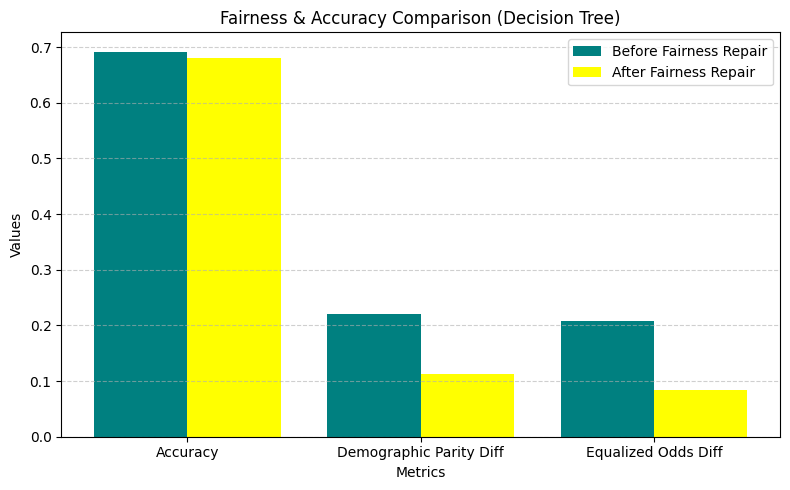

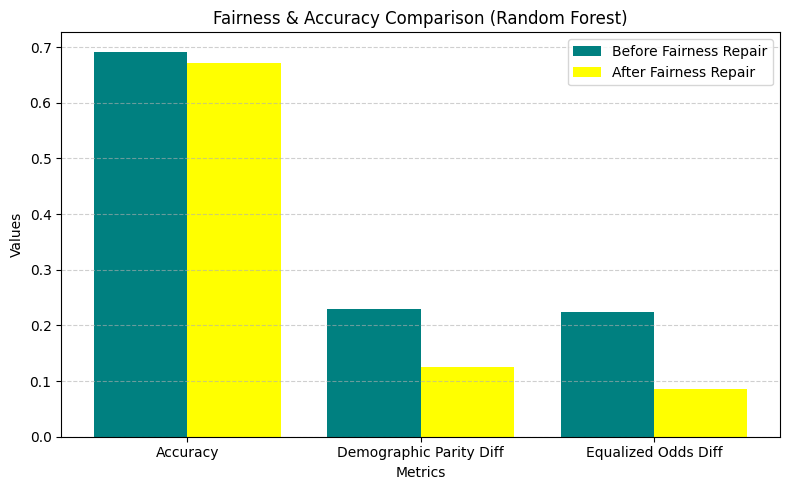

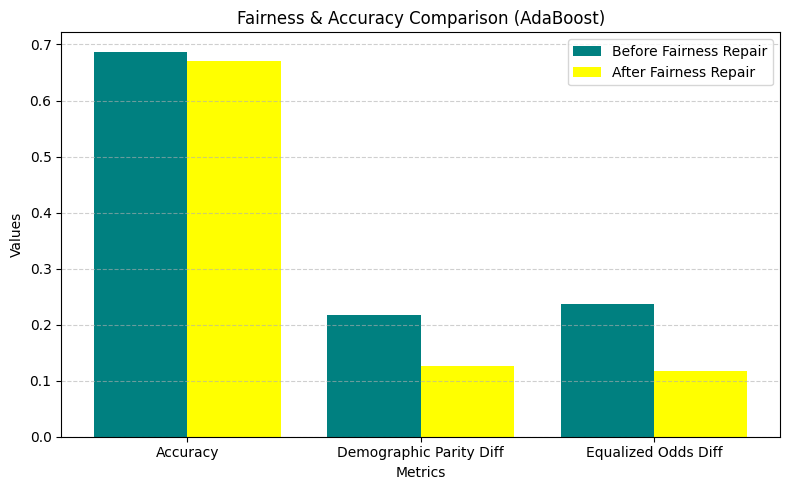

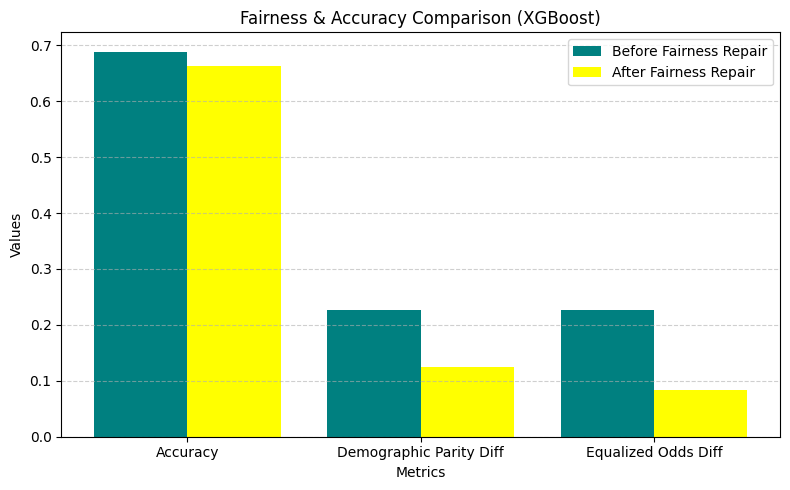

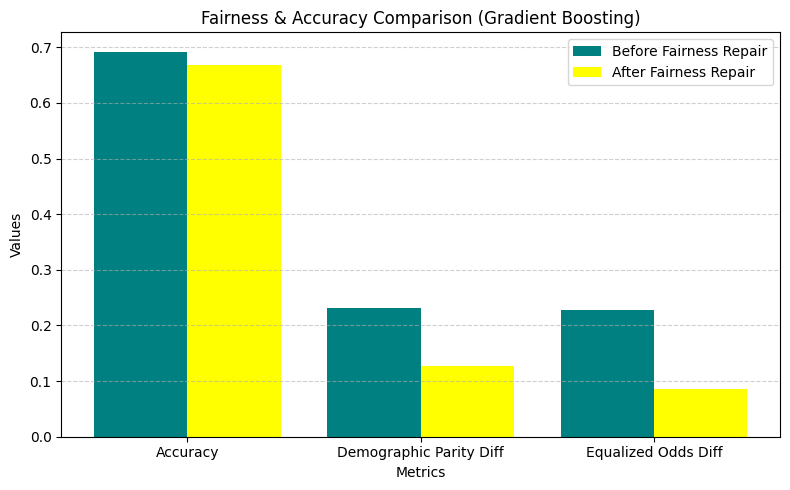

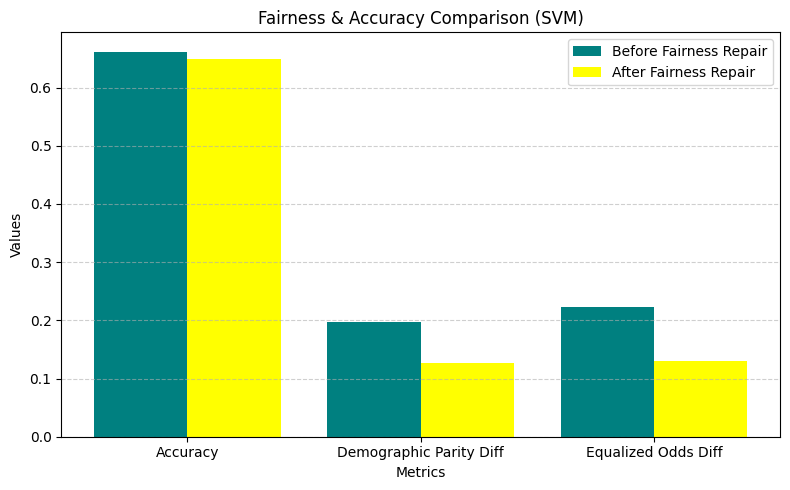

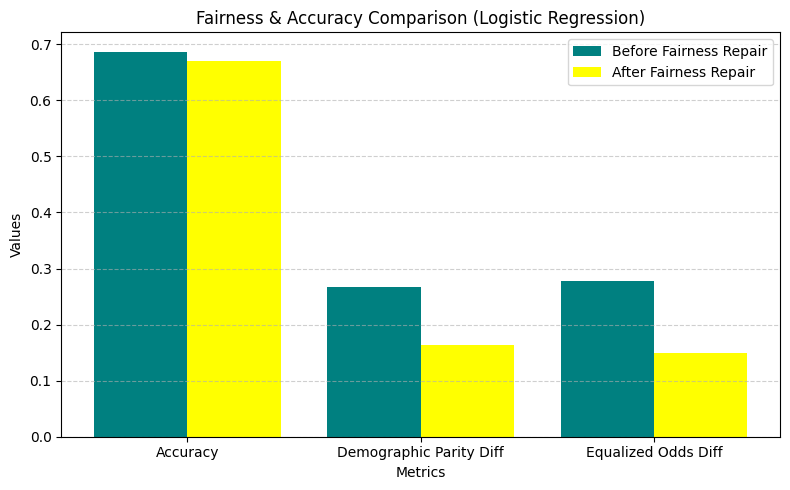

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = [
    "Decision Tree", "Random Forest", "AdaBoost", "XGBoost",
    "Gradient Boosting", "SVM", "Logistic Regression"
]

acc_befores = [
    0.6919168591224019, 0.6919168591224019, 0.68729792147806,
    0.6886836027713625, 0.692378752886836, 0.6618937644341801, 0.6868360277136258
]
acc_afters = [
    0.6803700701044932, 0.6706703910614525, 0.6711322957198444,
    0.6637412587412588, 0.6688215742441054, 0.6489607390300231, 0.6706703910614525
]

dpd_befores = [
    0.21963113270067708, 0.23003477559832475, 0.21796409026624852,
    0.22609263016936876, 0.23113560433704317, 0.19682288357348307, 0.2671725867169512
]
dpd_afters = [
    0.11261674421146844, 0.12571822883573486, 0.12533768555111954,
    0.12537313432835818, 0.12771816083734596, 0.12667915460526314, 0.16375473490902648
]

eod_befores = [
    0.20746214194490054, 0.2246122970260901, 0.236498814085021,
    0.22588943623426389, 0.22817916438606095, 0.22234081372012404, 0.278562306148513
]
eod_afters = [
    0.08332421091041775, 0.08495712461229699, 0.11753348729792148,
    0.08278636090987125, 0.08507567567567568, 0.1309622807017544, 0.1492516992572505
]

# Plot for each model
for i, model in enumerate(models):
    metrics = ["Accuracy", "Demographic Parity Diff", "Equalized Odds Diff"]
    before_values = [acc_befores[i], dpd_befores[i], eod_befores[i]]
    after_values = [acc_afters[i], dpd_afters[i], eod_afters[i]]

    x = np.arange(len(metrics))
    bar_width = 0.4

    plt.figure(figsize=(8, 5))
    plt.bar(x - bar_width/2, before_values, bar_width, label="Before Fairness Repair", color="teal")
    plt.bar(x + bar_width/2, after_values, bar_width, label="After Fairness Repair", color="yellow")

    plt.xlabel("Metrics")
    plt.ylabel("Values")
    plt.title(f"Fairness & Accuracy Comparison ({model})")
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

# **EDA & DATA CLEANING**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              7214 non-null   int64
 1   sex              7214 non-null   int64
 2   race             7214 non-null   int64
 3   priors_count     7214 non-null   int64
 4   two_year_recid   7214 non-null   int64
 5   c_charge_degree  7214 non-null   int64
dtypes: int64(6)
memory usage: 338.3 KB


```7214 entries with no missing values — a great start!```

In [ ]:
df.head()

,age,sex,race,priors_count,two_year_recid,c_charge_degree
0,69,1,0,0,0,1
1,34,1,1,0,1,1
2,24,1,1,4,1,1
3,23,1,1,1,0,1
4,43,1,0,2,0,1


**6 columns:**

*age, priors_count* – Continuous/discrete numeric features.

*sex, race, two_year_recid, c_charge_degree* – These are categorical, though currently stored as integers.

- Only 2 unique values for sex, race, and c_charge_degree suggests binary encoding.


In [ ]:
# Show column-wise unique counts to spot categorical columns
df.nunique()

,0
age,65
sex,2
race,2
priors_count,37
two_year_recid,2
c_charge_degree,2


In [ ]:
# Check for duplicate rows

duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
duplicate_rows.head()

Number of duplicate rows: 3938


,age,sex,race,priors_count,two_year_recid,c_charge_degree
79,27,1,0,1,1,1
86,22,1,1,2,1,1
91,21,1,0,1,1,1
139,31,1,1,1,0,0
162,30,1,1,1,0,1


**3,938 duplicate rows out of 7,214**
- Over 54% of the dataset!

<BR>
Duplicates can severely distort distributions, bias modeling, and even inflate model confidence, making it think it’s seen these patterns more often than it actually has.

<BR>

- **Real scenario:** Two different people could coincidentally be the same age, gender, race, have the same priors count, reoffend similarly, and have the same charge type.

- But for this dataset, we don’t have identifiers like names, timestamps, or IDs, so we can’t verify if they’re truly duplicates or just statistically similar individuals.


### **Analyze Duplicate Distribution**

In [ ]:
# Count how often each duplicate appears
duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='Count')
duplicate_counts_sorted = duplicate_counts.sort_values('Count', ascending=False)
duplicate_counts_sorted.head(10)

,age,sex,race,priors_count,two_year_recid,c_charge_degree,Count
108,21,1,1,1,1,1,31
104,21,1,1,0,1,1,28
102,21,1,1,0,0,1,25
164,22,1,1,0,1,1,24
168,22,1,1,1,1,1,24
86,21,1,0,0,1,1,24
295,24,1,0,0,0,1,22
238,23,1,1,0,0,1,21
55,20,1,1,1,1,1,21
106,21,1,1,1,0,1,21


This strongly suggests duplicates are artifacts, not real individual cases. Especially since:

We're working with the COMPAS dataset, which is known to contain some redundancy.

There are no unique identifiers (like case numbers or names) to differentiate rows.

These repetitions are skewing the data distributions and could bias model training, especially toward overrepresented profiles (e.g., young Black males with low priors).

<ipython-input-10-100bd1414d3d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race', data=df, palette='Set2')


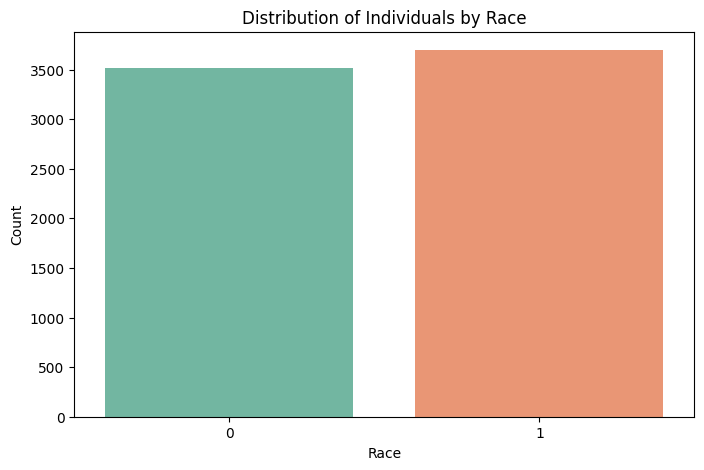

In [ ]:
# First Bias Check: race Distribution

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='race', data=df, palette='Set2')
plt.title("Distribution of Individuals by Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

- Near-even distribution between the two racial groups labeled 0 and 1 — that's actually balanced!

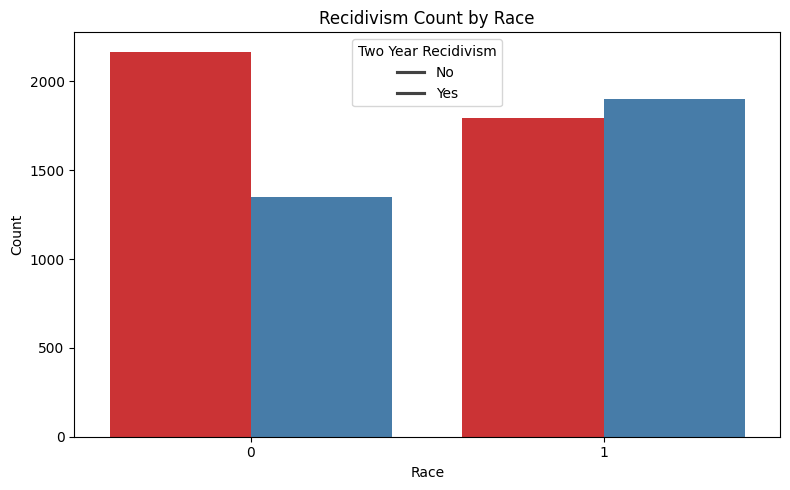

In [ ]:
# Recidivism Rate by Race

recid_race = df.groupby(['race', 'two_year_recid']).size().reset_index(name='count')

plt.figure(figsize=(8, 5))
sns.barplot(data=recid_race, x='race', y='count', hue='two_year_recid', palette='Set1')
plt.title("Recidivism Count by Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.legend(title="Two Year Recidivism", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


**From what we’re seeing:**

Race 0 (e.g., likely White):
🔴 More people did not recidivate than did (taller red bar vs. blue).

Race 1 (e.g., likely Black):
🔵 More people did recidivate than didn’t (taller blue bar vs. red).



```
This visual shows disparate outcomes between racial groups — which can be early evidence of racial bias in the dataset or in the way recidivism is measured.

It’s exactly this kind of imbalance that fairness-aware machine learning attempts to address.
```



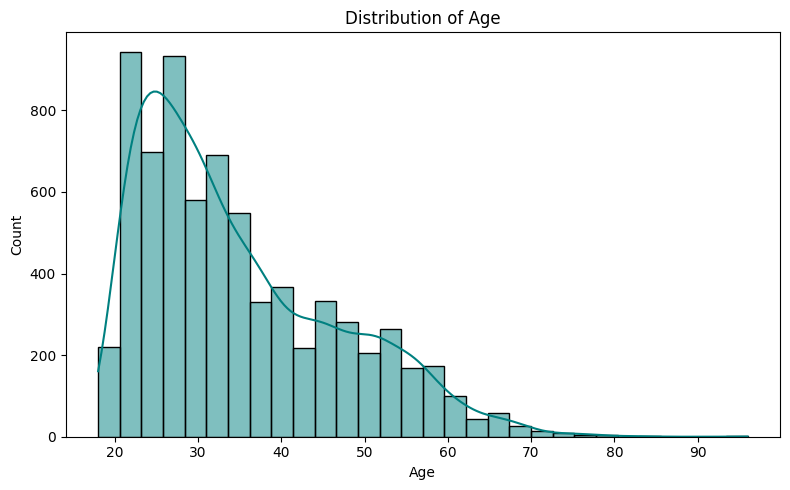

In [ ]:
# Skewness in Age Distribution

plt.figure(figsize=(8, 5))
sns.histplot(df['age'], kde=True, bins=30, color='teal')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Interpretation of the Age Distribution Plot:
The distribution is right-skewed (positively skewed).

Most individuals are clustered in the 20–35 age range, tapering off sharply as age increases.

Very few people are over 60, but they do exist — leading to a long tail.



####  **Log the skewness value before any transformation.**

- Applying a logarithmic transformation to reduce skewness or compress the scale of a variable.

- Few very large values (outliers) can dominate the distribution. Applying ```log()``` flattens these big values, making the distribution more normal-shaped and easier for models to handle.

In [ ]:
# Measure skewness
from scipy.stats import skew

age_skew = skew(df['age'])
print(f"Skewness of 'age': {age_skew:.3f}")


Skewness of 'age': 0.909


- Confirms a moderate to high positive skew.

### **Apply a Log Transformation**

Apply ```np.log1p()``` (log(1+x)) to age:

- Handles zeroes safely.

- Compresses the tail.

- Makes age more normally distributed.

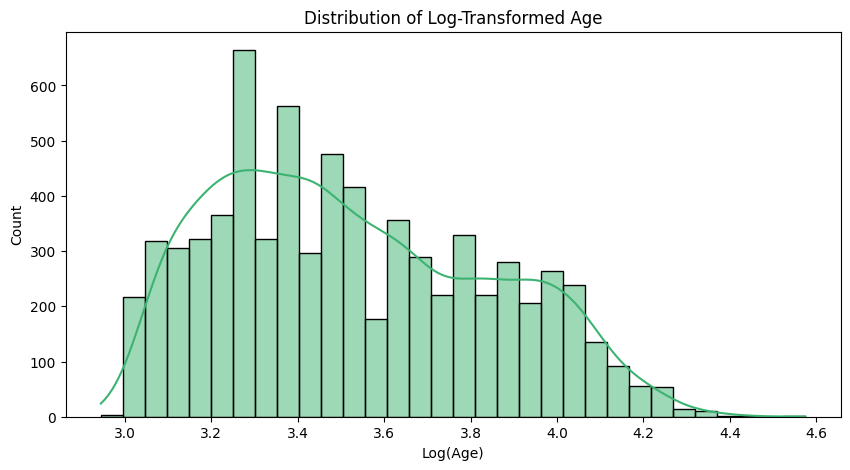

Skewness after log transformation: 0.396


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Apply log transformation
df['log_age'] = np.log1p(df['age'])

# Plot distribution after transformation
plt.figure(figsize=(10, 5))
sns.histplot(df['log_age'], kde=True, color='mediumseagreen')
plt.title('Distribution of Log-Transformed Age')
plt.xlabel('Log(Age)')
plt.ylabel('Count')
plt.show()

# Check new skewness
log_age_skew = skew(df['log_age'])
print(f"Skewness after log transformation: {log_age_skew:.3f}")

### **Drop exact duplicates**

In [ ]:
df = df.drop_duplicates()
print(f"New shape after dropping duplicates: {df.shape}")

New shape after dropping duplicates: (3276, 7)


### **Feature Engineering**

**1. Encoding Categorical Variables**

- ```sex:``` 0 or 1 — already numeric ✅
- ```race:``` 0 or 1 — numeric ✅
- ```c_charge_degree:``` numeric

In [ ]:
print(df['c_charge_degree'].unique())

[1 0]


if it was not numeric
```
df['c_charge_degree'] = df['c_charge_degree'].map({'F': 0, 'M': 1})
```

**2. Scaling**

To use models sensitive to scale (e.g., logistic regression, SVMs), we should standardize or normalize numerical features like:

age (or log_age if you're using the transformed version)

priors_count

In [ ]:
#  Re-running the log transform on the new df (after dropping duplicates)

df['log_age'] = np.log1p(df['age'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['age', 'priors_count']] = scaler.fit_transform(df[['age', 'priors_count']])

In [ ]:
df.head()

,age,sex,race,priors_count,two_year_recid,c_charge_degree,log_age
0,2.411632,1,0,-0.905881,0,1,4.248495
1,-0.381448,1,1,-0.905881,1,1,3.555348
2,-1.179471,1,1,-0.235298,1,1,3.218876
3,-1.259274,1,1,-0.738235,0,1,3.178054
4,0.336773,1,0,-0.570589,0,1,3.784190


In [ ]:
df.drop('age', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['log_age', 'priors_count']] = scaler.fit_transform(df[['log_age', 'priors_count']])

In [ ]:
df.head()

,sex,race,priors_count,two_year_recid,c_charge_degree,log_age
0,1,0,-0.905881,0,1,1.969694
1,1,1,-0.905881,1,1,-0.254955
2,1,1,-0.235298,1,1,-1.334860
3,1,1,-0.738235,0,1,-1.465878
4,1,0,-0.570589,0,1,0.479510


### **Normalize/Standardize Numerical Features**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select the columns to scale
cols_to_scale = ['log_age', 'priors_count']

# Apply scaling
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [ ]:
df[cols_to_scale].describe()

,log_age,priors_count
count,3.276000e+03,3.276000e+03
mean,8.675735e-18,1.735147e-17
std,1.000153e+00,1.000153e+00
min,-2.215662e+00,-9.058805e-01
25%,-7.497004e-01,-7.382348e-01
50%,-7.660426e-02,-4.029434e-01
75%,8.249494e-01,4.352853e-01
max,3.016681e+00,5.464657e+00


In [ ]:
print(df[['sex', 'race', 'c_charge_degree']].nunique())
print(df[['sex', 'race', 'c_charge_degree']].dtypes)

sex                2
race               2
c_charge_degree    2
dtype: int64
sex                int64
race               int64
c_charge_degree    int64
dtype: object


### **Detect and Handle Outliers**

In [ ]:
from scipy.stats import zscore

# Calculate z-scores for numerical columns
z_scores = np.abs(zscore(df[['log_age', 'priors_count']]))

# Filter rows where both features have Z-scores less than 3 (i.e., not extreme outliers)
df_clean = df[(z_scores < 3).all(axis=1)]

print(f"Original shape: {df.shape}")
print(f"New shape after outlier removal: {df_clean.shape}")


Original shape: (3276, 6)
New shape after outlier removal: (3217, 6)


### **Handle Class Imbalance**

we'll apply SMOTE (for oversampling) or Undersampling accordingly

Class distribution:
 two_year_recid
1    1666
0    1610
Name: count, dtype: int64


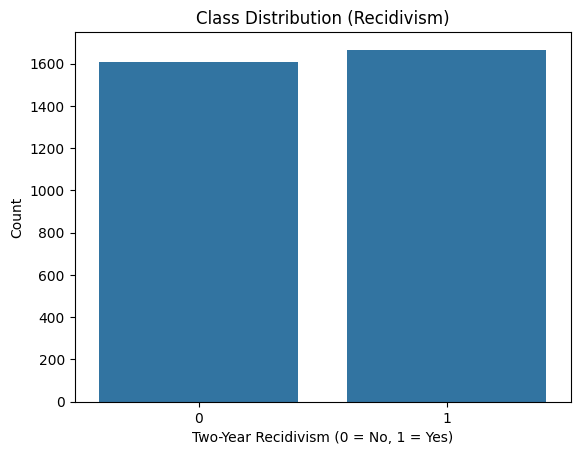

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
class_counts = df['two_year_recid'].value_counts()
print("Class distribution:\n", class_counts)

# Visualize
sns.countplot(data=df, x='two_year_recid')
plt.title("Class Distribution (Recidivism)")
plt.xlabel("Two-Year Recidivism (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# **RE-TRAINING MODEL AFTER CLEANING**

## Without FairLearn

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns='two_year_recid')
y = df['two_year_recid']

# Assuming 'sex' is our sensitive attribute
s = df['sex']

# Make sure this split happens when you split X and y:
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, s, test_size=0.2, random_state=42, stratify=y)

# # Split dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Show shapes
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (2620, 5)
Test set shape: (656, 5)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Define all 7 models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Evaluate all models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=s_test)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Demographic Parity Diff': dpd,
        'Equalized Odds Diff': eod
    })

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:32:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  Demographic Parity Diff  Equalized Odds Diff
6                  SVM  0.618902                 0.145198             0.160492
0  Logistic Regression  0.611280                 0.247568             0.281892
3    Gradient Boosting  0.603659                 0.160261             0.203571
5             AdaBoost  0.599085                 0.137416             0.147508
1        Decision Tree  0.596037                 0.148797             0.179597
4              XGBoost  0.524390                 0.140018             0.251519
2        Random Forest  0.393293                 0.128613             0.272525


## With FairLearn

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Store results
fairlearn_results = []

# Loop through all models
for name, model in models.items():
    print(f"\n🔧 Training and applying Fairlearn to {name}...")

    # Fit model
    model.fit(X_train, y_train)

    # Predict (pre-fairness)
    y_pred = model.predict(X_test)
    acc_before = accuracy_score(y_test, y_pred)
    dpd_before = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
    eod_before = equalized_odds_difference(y_test, y_pred, sensitive_features=s_test)

    # Apply ThresholdOptimizer from Fairlearn
    try:
        postproc = ThresholdOptimizer(
            estimator=model,
            constraints="demographic_parity",  # You can switch to "equalized_odds" if needed
            predict_method="predict_proba",
            prefit=True
        )

        postproc.fit(X_test, y_test, sensitive_features=s_test)
        y_pred_fair = postproc.predict(X_test, sensitive_features=s_test)

        # Post-fairness metrics
        acc_after = accuracy_score(y_test, y_pred_fair)
        dpd_after = demographic_parity_difference(y_test, y_pred_fair, sensitive_features=s_test)
        eod_after = equalized_odds_difference(y_test, y_pred_fair, sensitive_features=s_test)

    except Exception as e:
        print(f"❌ Could not apply Fairlearn on {name}: {e}")
        acc_after = dpd_after = eod_after = None

    # Append results
    fairlearn_results.append({
        "Model": name,
        "Accuracy Before": acc_before,
        "Accuracy After": acc_after,
        "DPD Before": dpd_before,
        "DPD After": dpd_after,
        "EOD Before": eod_before,
        "EOD After": eod_after
    })

# Create DataFrame
fair_df = pd.DataFrame(fairlearn_results)
print("\n📊 Fairlearn Results Summary:\n")
print(fair_df.sort_values(by="Accuracy Before", ascending=False))


🔧 Training and applying Fairlearn to Logistic Regression...

🔧 Training and applying Fairlearn to Decision Tree...

🔧 Training and applying Fairlearn to Random Forest...

🔧 Training and applying Fairlearn to Gradient Boosting...

🔧 Training and applying Fairlearn to XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:32:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.         0.00197368 0.         0.         1.
 0.         0.         0.         1.         0.         0.00197368
 0.00197368 1.         0.00197368 1.         0.         1.
 0.00197368 0.         0.00197368 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00197368 1.         0.         0.
 1.         0.         0.00197368 0.         0.         0.
 0.         0.         0.00197368 0.00197368 0.         0.
 0.         0.         0.         0.00197368 0.         0.
 0.         1.       


🔧 Training and applying Fairlearn to AdaBoost...

🔧 Training and applying Fairlearn to SVM...

📊 Fairlearn Results Summary:

                 Model  Accuracy Before  Accuracy After  DPD Before  \
6                  SVM         0.618902        0.626524    0.145198   
0  Logistic Regression         0.611280        0.632622    0.247568   
3    Gradient Boosting         0.603659        0.617378    0.160261   
5             AdaBoost         0.599085        0.623476    0.137416   
1        Decision Tree         0.596037        0.609756    0.148797   
4              XGBoost         0.524390        0.567073    0.140018   
2        Random Forest         0.393293        0.518293    0.128613   

   DPD After  EOD Before  EOD After  
6   0.000202    0.160492   0.062500  
0   0.000368    0.281892   0.065551  
3   0.016311    0.203571   0.050000  
5   0.012296    0.147508   0.055118  
1   0.008459    0.179597   0.043110  
4   0.000618    0.251519   0.035531  
2   0.016038    0.272525   0.041831  


## **PERFORMANCE COMPARISION**

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


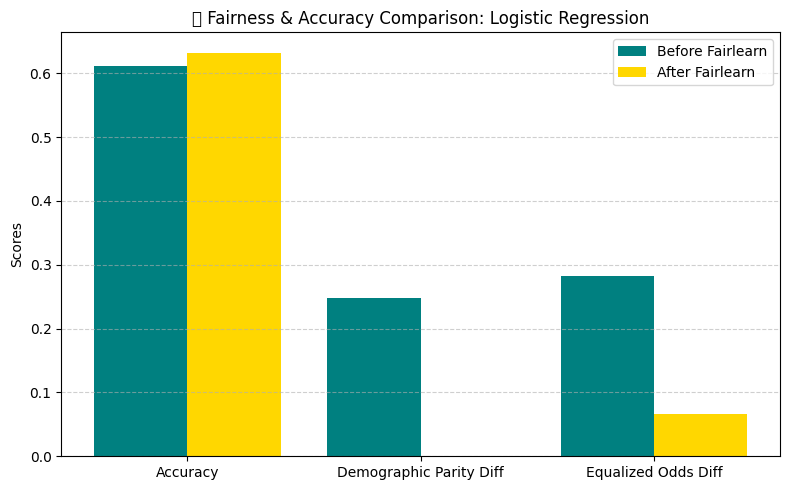

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


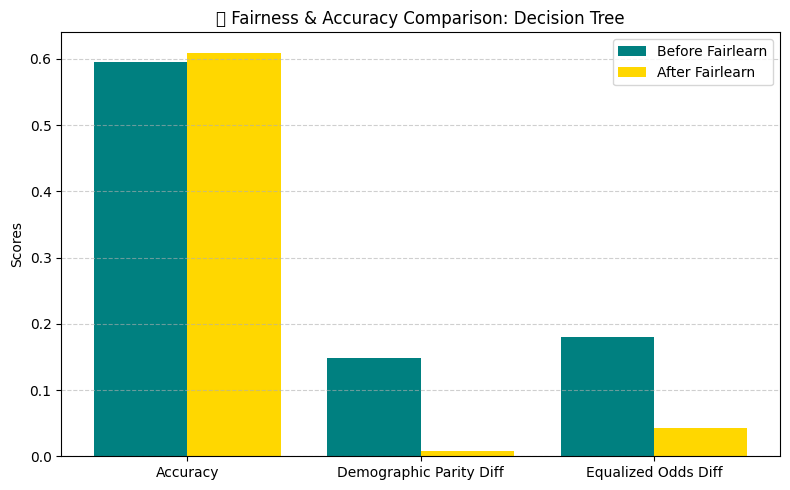

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


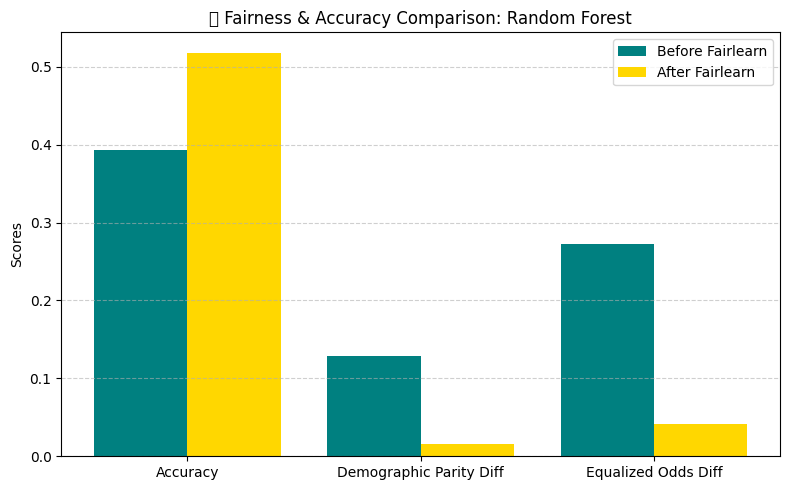

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


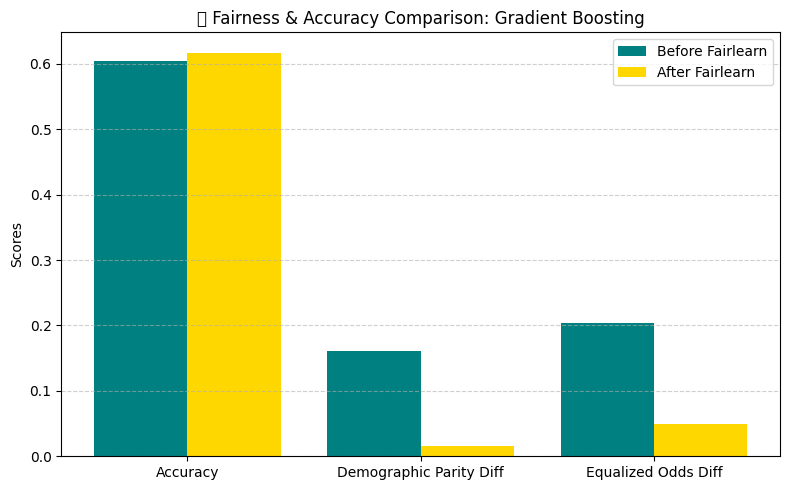

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


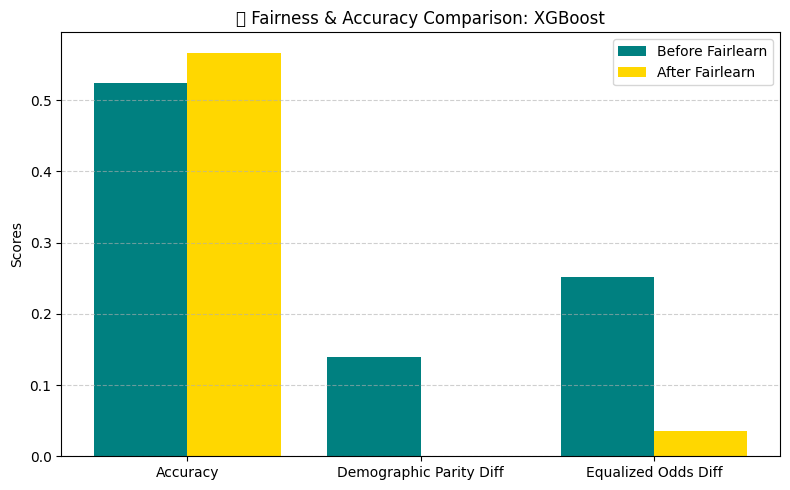

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


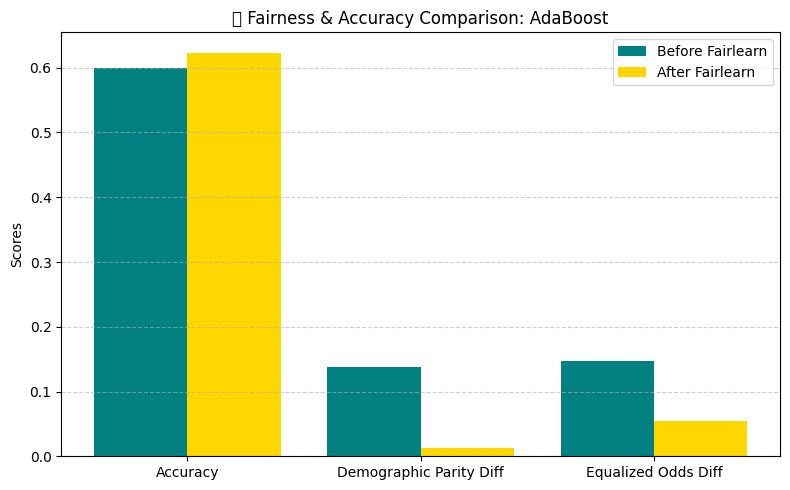

<ipython-input-31-40fe5dba2d44>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


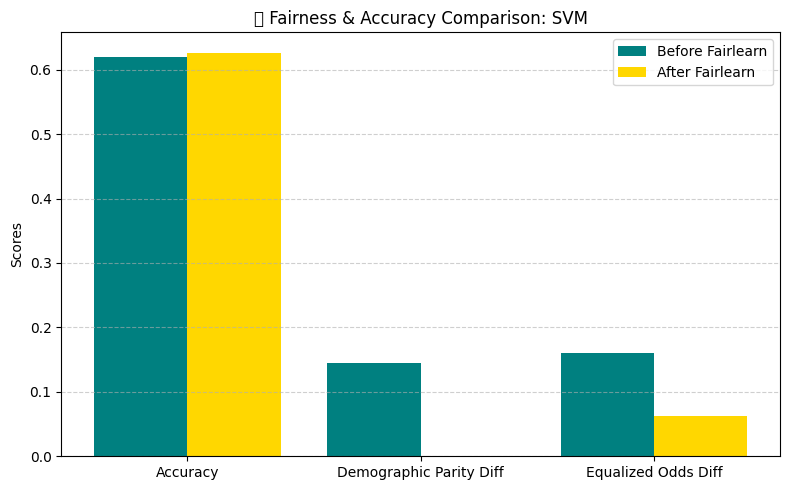

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If not already in lists
models_ordered = fair_df['Model'].tolist()

acc_befores = fair_df['Accuracy Before'].tolist()
acc_afters = fair_df['Accuracy After'].tolist()

dpd_befores = fair_df['DPD Before'].tolist()
dpd_afters = fair_df['DPD After'].tolist()

eod_befores = fair_df['EOD Before'].tolist()
eod_afters = fair_df['EOD After'].tolist()

# Plot per model
for i, model in enumerate(models_ordered):
    metrics = ["Accuracy", "Demographic Parity Diff", "Equalized Odds Diff"]
    before_vals = [acc_befores[i], dpd_befores[i], eod_befores[i]]
    after_vals = [acc_afters[i], dpd_afters[i], eod_afters[i]]

    x = np.arange(len(metrics))
    bar_width = 0.4

    plt.figure(figsize=(8, 5))
    plt.bar(x - bar_width/2, before_vals, bar_width, label="Before Fairlearn", color="teal")
    plt.bar(x + bar_width/2, after_vals, bar_width, label="After Fairlearn", color="gold")

    plt.title(f"📊 Fairness & Accuracy Comparison: {model}")
    plt.xticks(x, metrics)
    plt.ylabel("Scores")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
